In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import pandas as pd
from scipy import stats

from scipy.spatial import distance

import turboBrainUtils as tb 

# Plot stuff

time ij list 14.096762657165527


<IPython.core.display.Javascript object>


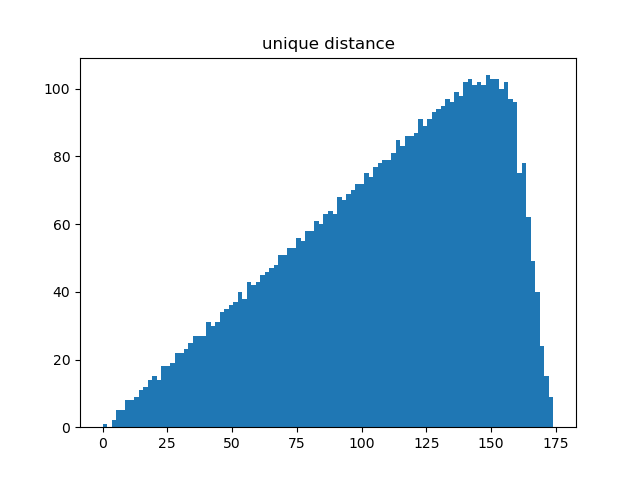

<IPython.core.display.Javascript object>


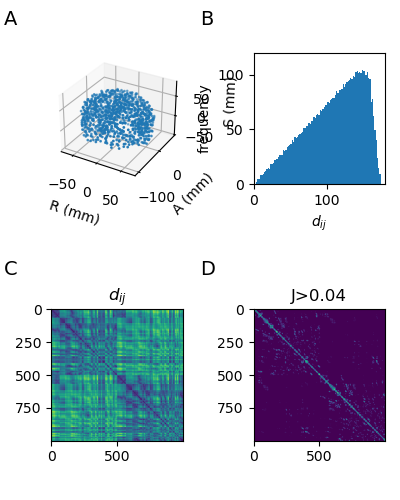

In [4]:
runs = 40
passi = 100#200
autapse = True
randomize = False

# # Parcellizzazione
# https://www.sciencedirect.com/science/article/pii/S2211124720314601?via%3Dihub
df = pd.read_csv('Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
df.head()
X = df['R']
Y = df['A']
Z = df['S']
N=len(X)

coords = np.array([X,Y,Z]).T
dist = distance.cdist(coords, coords, 'euclidean')
uniqDist,iListList,jListList = tb.sortIJbyDist(dist,N)
plt.figure()
h,bins,f=plt.hist(uniqDist,bins=100)
plt.title('unique distance')

lamda = 0.18#0.18
J = tb.makeJ(dist,lamda,autapse,randomize)

#tb.plotInitalJ(X, Y, Z,dist,J)
tb.plotInitalJ(X, Y, Z,dist,J,uniqDist)

# Read states

In [5]:
# read states and load states container

df = pd.read_csv('parametersRuns-autapse.csv')
lambdas = np.unique(df['lambdas'].values)
print(lambdas)

df3 = pd.read_csv('SRuns-autapse.csv')

states = np.zeros((len(lambdas),runs,N))
SName = list(df3.columns)#[1:]

for lindx,lambd in enumerate(lambdas):
    print(lindx,lambd,1./lambd)
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = SName[40*lindx:40*(lindx+1)]
    states[lindx,:,:] = df3[cols].values.T
print(states.shape)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29]
0 0.1 10.0
1 0.11 9.090909090909092
2 0.12 8.333333333333334
3 0.13 7.692307692307692
4 0.1399999999999999 7.142857142857148
5 0.1499999999999999 6.6666666666666705
6 0.1599999999999999 6.250000000000004
7 0.1699999999999999 5.882352941176474
8 0.1799999999999999 5.555555555555558
9 0.1899999999999999 5.263157894736845
10 0.1999999999999999 5.000000000000003
11 0.2099999999999999 4.761904761904764
12 0.2199999999999999 4.545454545454548
13 0.2299999999999999 4.347826086956523
14 0.2399999999999999 4.166666666666668
15 0.2499999999999999 4.000000000000002
16 0.2599999999999999 3.8461538461538476
17 0.2699999999999999 3.703703703703705
18 0.2799999999999999 3.5714285714285725
19 0.2899999999999999 3.4482758620689666
(20, 40, 1000)


[8 7]


<IPython.core.display.Javascript object>


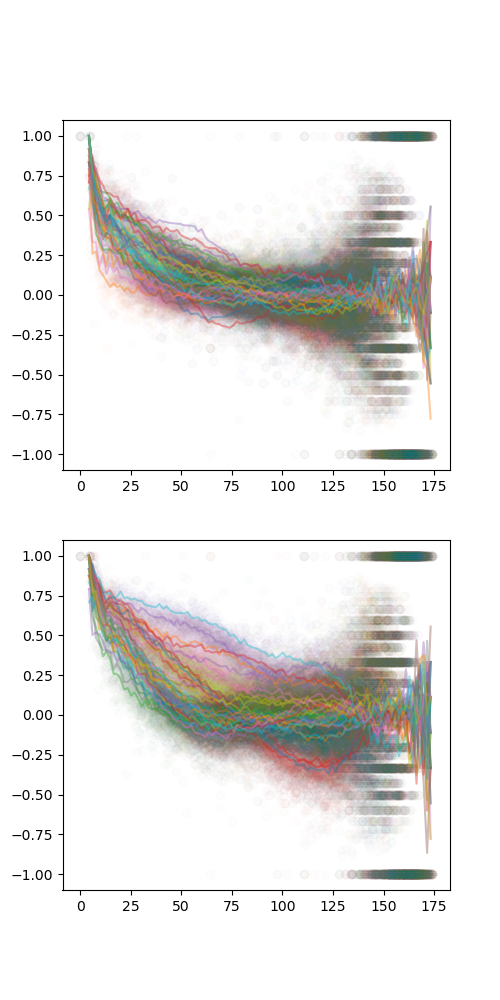

8 0.1799999999999999 5.555555555555558


/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


7 0.1699999999999999 5.882352941176474


In [5]:
def computeBr(statesRun,uniqDist,iListList,jListList):
    BdRun = []
    for d,iList,jList in zip(uniqDist,iListList,jListList):
        #print(d,np.sum(dist==d))
        cors = np.mean(statesRun[np.array(iList)]*statesRun[np.array(jList)])
        BdRun.append(cors)
    return BdRun

linxs = np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

f,axs = plt.subplots(2,1,figsize=(5,10))
rs = [0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])]

for i,lindx in enumerate(linxs):
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    for r in range(runs):
        BdRun = computeBr(states[lindx,r,:],uniqDist,iListList,jListList)
        if r < 10:
            axs[i].scatter(uniqDist,BdRun,alpha=0.01)
        binnedBdrun = []
        for ra,rb in zip(bins[:-1],bins[1:]):
            gate = np.logical_and(uniqDist>=ra, uniqDist<=rb)
            binnedBdrun.append(np.mean(np.array(BdRun)[gate]))
        binnedBdrun = np.array(binnedBdrun)
        axs[i].plot(rs,binnedBdrun,alpha=0.4)

[8 7]


<IPython.core.display.Javascript object>


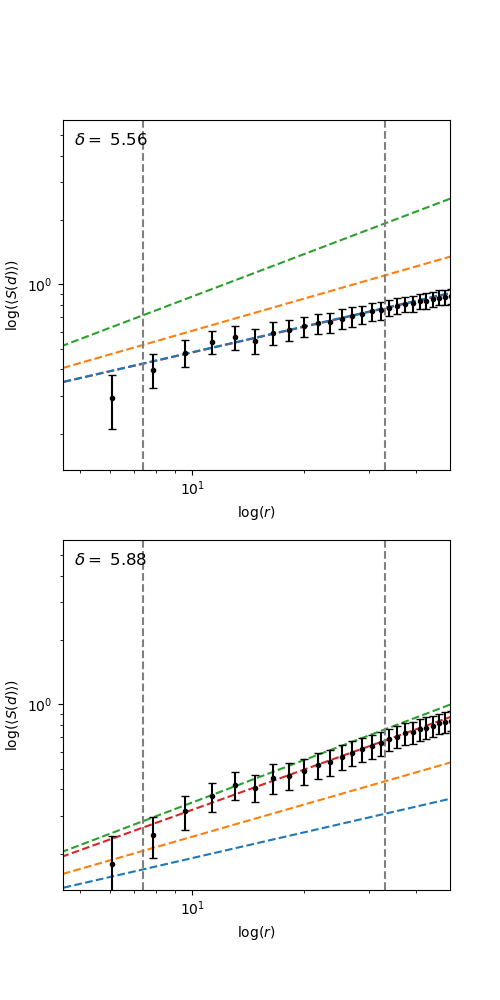

8 0.1799999999999999 5.555555555555558


/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


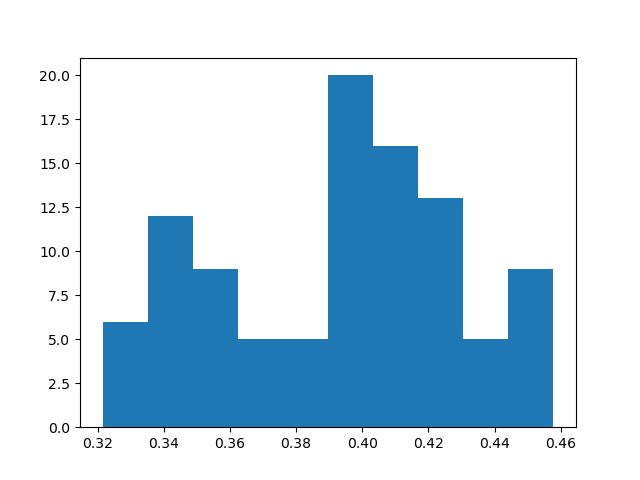

/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


alpha 0.39861390292702686 2/5 0.4 2/3 0.6666666666666666
7 0.1699999999999999 5.882352941176474


<IPython.core.display.Javascript object>


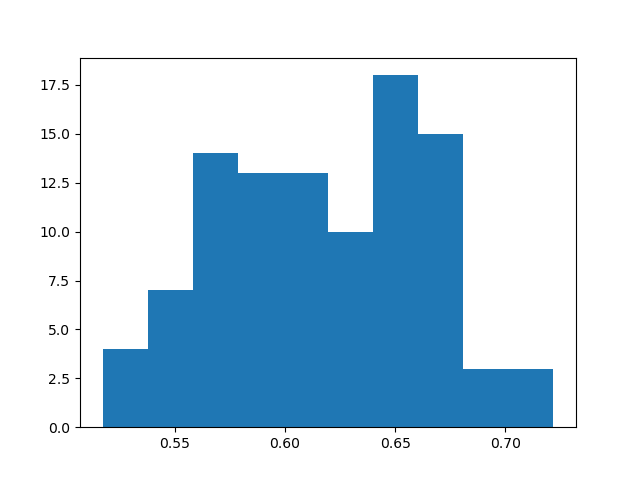

alpha 0.6256412673161387 2/5 0.4 2/3 0.6666666666666666


In [5]:
fitxlim = 3.5 


def resample(x,y,n_bootstraps):
    x_bs = []
    y_bs = []
    sample_size = len(x)
    idx = range(sample_size) #[i for i in range(sample_size)]
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        x_b = x[sidx]
        y_b = y[sidx]
        x_bs.append(x_b)
        y_bs.append(y_b)
    return x_bs,y_bs

def computeRegression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha

def computeBr(statesRun,uniqDist,iListList,jListList):
    BdRun = []
    for d,iList,jList in zip(uniqDist,iListList,jListList):
        #print(d,np.sum(dist==d))
        cors = np.mean(statesRun[np.array(iList)]*statesRun[np.array(jList)])
        BdRun.append(cors)
    return BdRun

linxs = np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

f,axs = plt.subplots(2,1,figsize=(5,10))
rs = [0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])]

for i,lindx in enumerate(linxs):
    BdRuns = []
    SdRuns = []
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    binnedBd = {r:[] for r in rs}
    for r in range(runs):
        BdRun = computeBr(states[lindx,r,:],uniqDist,iListList,jListList)
        BdRuns.append(BdRun)
        SdRuns.append(BdRun[0]-BdRun[2:])
    binnedSd_mean = []
    binnedSd_std = []
    for ra,rb in zip(bins[:-1],bins[1:]):
        gate = np.logical_and(uniqDist[2:]>=ra, uniqDist[2:]<=rb)
        binnedSd_mean.append(np.mean(np.array(SdRuns)[:,gate]))
        binnedSd_std.append(np.std(np.array(SdRuns)[:,gate]))
        #print(np.mean(np.array(BdRuns)[:,gate]))
    #axs[i].errorbar(rs,binnedSd_mean,yerr=binnedSd_std)
    
    x=np.log(rs)
    y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    alpha = computeRegression(x,y)
    xbs,ybs = resample(x,y,n_bootstraps=100)
    alphas = [computeRegression(x,y) for x,y in zip(xbs,ybs)]
    #print('alpha0 ',alpha[0],np.array(alphas)[:,0])
    plt.figure()
    plt.hist(np.array(alphas)[:,0])
    
    xline = np.arange(1,5.5,0.1) #np.array([1,5.5])
    axs[i].plot(np.exp(xline), np.exp(alpha[0]*xline + alpha[1]), '--',color='tab:red',label='slope fit '+"%.2f" % alpha[0])
    
    
    
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.4)]),'--',color='tab:blue',label='slope = 2/5')
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.5)]),'--',color='tab:orange',label='slope = 1/2 Deco')
    axs[i].plot(np.exp([0,5.5]),np.exp([alpha[1],alpha[1] + 5.5*(0.66)]),'--',color='tab:green',label='slope = 2/3 Turbulence')
    axs[i].errorbar(rs,binnedSd_mean,yerr=3*np.array(binnedSd_std)/np.sqrt(40),fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xticks(np.exp(np.arange(1.5,3.9,0.5)))
    axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].minorticks_off()
    axs[i].set_xticklabels(np.arange(1.5,3.9,0.5))
    axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs[i].set_xlim((np.exp(1.5),np.exp(3.9)))
    axs[i].set_ylim((np.exp(-2),np.exp(1.77)))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    axs[i].set_ylabel(r'$\log( \langle S(d) \rangle)$')
    axs[i].loglog()
    delt = 1./lambdas[lindx]
    axs[i].text(4.8, 4.5, r'$\delta = $ '+"%.2f" % delt, fontsize=12)
    print('alpha',alpha[0],'2/5',2./5.,'2/3',2./3.)


In [7]:
linxs = range(len(lambdas)-4,-1,-4)#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(list(linxs))

[16, 12, 8, 4, 0]


[11, 10, 9, 8, 7, 6, 5]


<IPython.core.display.Javascript object>


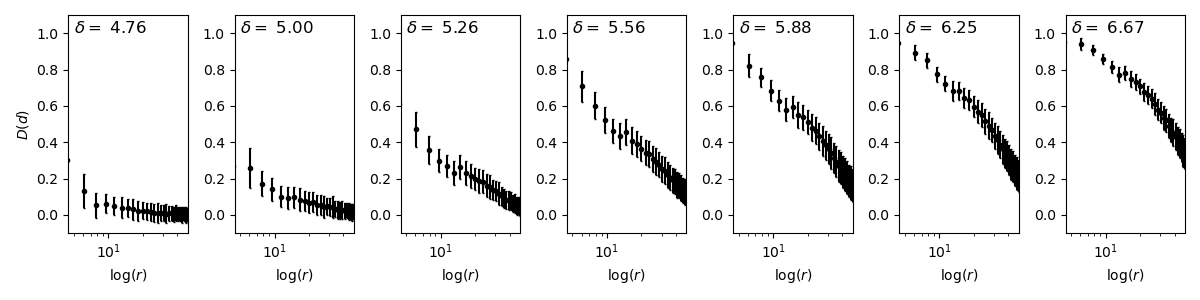

11 0.2099999999999999 4.761904761904764
10 0.1999999999999999 5.000000000000003
9 0.1899999999999999 5.263157894736845
8 0.1799999999999999 5.555555555555558
7 0.1699999999999999 5.882352941176474
6 0.1599999999999999 6.250000000000004
5 0.1499999999999999 6.6666666666666705


In [17]:
fitxlim = 3.5 


def resample(x,y,n_bootstraps):
    x_bs = []
    y_bs = []
    sample_size = len(x)
    idx = range(sample_size) #[i for i in range(sample_size)]
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        x_b = x[sidx]
        y_b = y[sidx]
        x_bs.append(x_b)
        y_bs.append(y_b)
    return x_bs,y_bs

def computeRegression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha

def computeBr(statesRun,uniqDist,iListList,jListList):
    BdRun = []
    for d,iList,jList in zip(uniqDist,iListList,jListList):
        #print(d,np.sum(dist==d))
        cors = np.mean(statesRun[np.array(iList)]*statesRun[np.array(jList)])
        BdRun.append(cors)
    return BdRun

linxs = [11,10, 9, 8, 7, 6,5] #[12, 10, 8, 6, 4] #[16, 12, 8, 4, 0]#range(len(lambdas)-4,-1,-4)#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

#f,axs = plt.subplots(2,1,figsize=(5,10))
rs = [0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])]


f,axs = plt.subplots(1,7,figsize=(12,3))

for i,lindx in enumerate(linxs):
    BdRuns = []
    SdRuns = []
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    binnedBd = {r:[] for r in rs}
    for r in range(runs):
        BdRun = computeBr(states[lindx,r,:],uniqDist,iListList,jListList)
        BdRuns.append(BdRun[2:])
        SdRuns.append(BdRun[0]-BdRun[2:])
    binnedBd_mean = []
    binnedBd_std = []
    binnedSd_mean = []
    binnedSd_std = []
    for ra,rb in zip(bins[:-1],bins[1:]):
        gate = np.logical_and(uniqDist[2:]>=ra, uniqDist[2:]<=rb)
        binnedSd_mean.append(np.mean(np.array(SdRuns)[:,gate]))
        binnedSd_std.append(np.std(np.array(SdRuns)[:,gate]))
        binnedBd_mean.append(np.mean(np.array(BdRuns)[:,gate]))
        binnedBd_std.append(np.std(np.array(BdRuns)[:,gate]))
    axs[i].errorbar(rs,binnedBd_mean,yerr=3*np.array(binnedBd_std)/np.sqrt(40),fmt='k.', ecolor='black',  capsize=1, capthick=1)
    #axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    #axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xticks(np.exp(np.arange(1.5,3.9,0.5)))
    axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].minorticks_off()
    axs[i].set_xticklabels(np.arange(1.5,3.9,0.5))
    #axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    #axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs[i].set_xlim((np.exp(1.5),np.exp(3.9)))
    axs[i].set_ylim((-0.1,1.1))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    delt = 1./lambdas[lindx]
    #axs[i].text(np.exp(.5), 1.,r'$\delta = $ '+"%.2f" % delt, fontsize=12)
    axs[i].text(5., 1., r'$\delta = $ '+"%.2f" % delt, fontsize=12)
    axs[i].semilogx()
    
axs[0].set_ylabel(r'$D(d)$')
plt.tight_layout()

range(16, -1, -4)


<IPython.core.display.Javascript object>


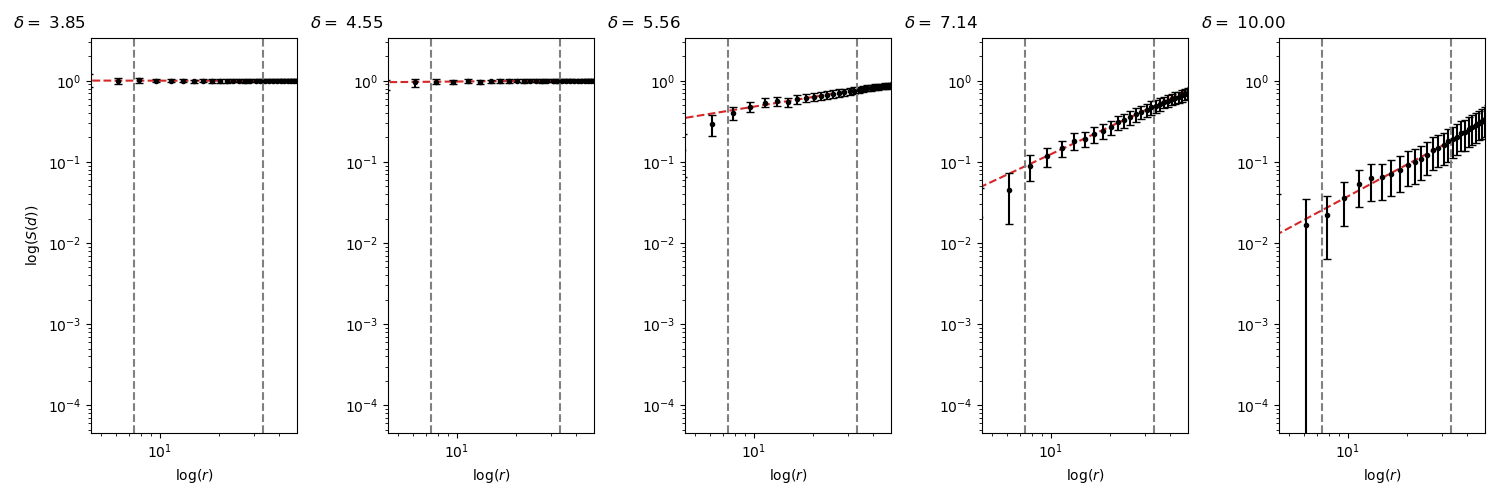

16 0.2599999999999999 3.8461538461538476
alpha0  -0.002931765045478532 0.0035501718118978974
12 0.2199999999999999 4.545454545454548
alpha0  0.02174137162283595 0.004400614400261796
8 0.1799999999999999 5.555555555555558
alpha0  0.39861390292702686 0.03345678145368209
4 0.1399999999999999 7.142857142857148
alpha0  1.1352997635847477 0.023042721746652506
0 0.1 10.0
alpha0  1.3097635569808208 0.08718632753032148


In [29]:
fitxlim = 3.5 


def resample(x,y,n_bootstraps):
    x_bs = []
    y_bs = []
    sample_size = len(x)
    idx = range(sample_size) #[i for i in range(sample_size)]
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        x_b = x[sidx]
        y_b = y[sidx]
        x_bs.append(x_b)
        y_bs.append(y_b)
    return x_bs,y_bs

def computeRegression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha

def computeBr(statesRun,uniqDist,iListList,jListList):
    BdRun = []
    for d,iList,jList in zip(uniqDist,iListList,jListList):
        #print(d,np.sum(dist==d))
        cors = np.mean(statesRun[np.array(iList)]*statesRun[np.array(jList)])
        BdRun.append(cors)
    return BdRun

linxs = range(len(lambdas)-4,-1,-4)#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

#f,axs = plt.subplots(2,1,figsize=(5,10))
rs = [0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])]


#f,axs = plt.subplots(1,5,figsize=(15,5))
f1,axs1 = plt.subplots(1,5,figsize=(15,5))

for i,lindx in enumerate(linxs):
    BdRuns = []
    SdRuns = []
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    binnedBd = {r:[] for r in rs}
    for r in range(runs):
        BdRun = computeBr(states[lindx,r,:],uniqDist,iListList,jListList)
        BdRuns.append(BdRun[2:])
        SdRuns.append(BdRun[0]-BdRun[2:])
    binnedBd_mean = []
    binnedBd_std = []
    binnedSd_mean = []
    binnedSd_std = []
    for ra,rb in zip(bins[:-1],bins[1:]):
        gate = np.logical_and(uniqDist[2:]>=ra, uniqDist[2:]<=rb)
        binnedSd_mean.append(np.mean(np.array(SdRuns)[:,gate]))
        binnedSd_std.append(np.std(np.array(SdRuns)[:,gate]))
        binnedBd_mean.append(np.mean(np.array(BdRuns)[:,gate]))
        binnedBd_std.append(np.std(np.array(BdRuns)[:,gate])) 
        
    x=np.log(rs)
    y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    alpha = computeRegression(x,y)
    xbs,ybs = resample(x,y,n_bootstraps=100)
    alphas = [computeRegression(x,y) for x,y in zip(xbs,ybs)]
    print('alpha0 ',alpha[0],np.std(np.array(alphas)[:,0]))
    #plt.figure()
    #plt.hist(np.array(alphas)[:,0])
    
    xline = np.arange(1,5.5,0.1) #np.array([1,5.5])
    axs1[i].plot(np.exp(xline), np.exp(alpha[0]*xline + alpha[1]), '--',color='tab:red',label='slope fit '+"%.2f" % alpha[0])

        
    axs1[i].errorbar(rs,binnedSd_mean,yerr=3*np.array(binnedSd_std)/np.sqrt(40),fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs1[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs1[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs1[i].set_xticks(np.exp(np.arange(1.5,3.9,0.5)))
    axs1[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs1[i].minorticks_off()
    axs1[i].set_xticklabels(np.arange(1.5,3.9,0.5))
    #axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    #axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs1[i].set_xlim((np.exp(1.5),np.exp(3.9)))
    axs1[i].set_ylim((np.exp(-10),np.exp(1.2)))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs1[i].set_xlabel(r'$\log(r)$')
    
    axs1[i].loglog()
    delt = 1./lambdas[lindx]
    axs1[i].text(1.8, 4.5, r'$\delta = $ '+"%.2f" % delt, fontsize=12)

axs1[0].set_ylabel(r'$\log(S(d))$')
plt.tight_layout()

<IPython.core.display.Javascript object>


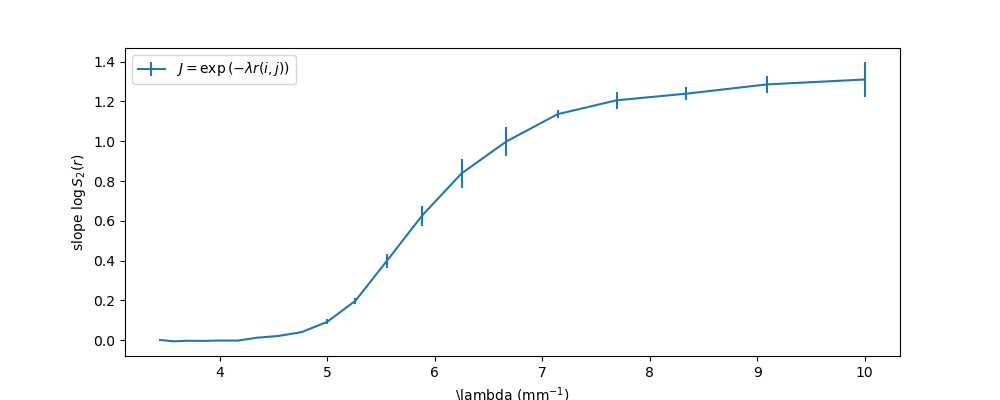

range(0, 20)
0 0.1 10.0
alpha0  1.3097635569808208 0.08786410201678074
1 0.11 9.090909090909092


/tmp/ipykernel_7383/517322473.py:65: RuntimeWarning: divide by zero encountered in log
  y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]


alpha0  1.285105871582675 0.04364844610376756
2 0.12 8.333333333333334
alpha0  1.238120517649307 0.03155677276085464
3 0.13 7.692307692307692
alpha0  1.2053263447332008 0.04370338415919374
4 0.1399999999999999 7.142857142857148
alpha0  1.1352997635847477 0.021118018279315875
5 0.1499999999999999 6.6666666666666705
alpha0  0.9984949309736056 0.07516474905780487
6 0.1599999999999999 6.250000000000004
alpha0  0.837928148672394 0.07246398384070035
7 0.1699999999999999 5.882352941176474
alpha0  0.6256412673161387 0.05108783373905504
8 0.1799999999999999 5.555555555555558
alpha0  0.39861390292702686 0.03377815076355592
9 0.1899999999999999 5.263157894736845
alpha0  0.19823490946881236 0.01603021601575264
10 0.1999999999999999 5.000000000000003
alpha0  0.09235000792440343 0.012215206831043973
11 0.2099999999999999 4.761904761904764
alpha0  0.04082317185513228 0.004683847218030643
12 0.2199999999999999 4.545454545454548
alpha0  0.02174137162283595 0.004991927515464108
13 0.2299999999999999 4.3

In [40]:
fitxlim = 3.5 


def resample(x,y,n_bootstraps):
    x_bs = []
    y_bs = []
    sample_size = len(x)
    idx = range(sample_size) #[i for i in range(sample_size)]
    for b in range(n_bootstraps):
        # obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=sample_size)
        x_b = x[sidx]
        y_b = y[sidx]
        x_bs.append(x_b)
        y_bs.append(y_b)
    return x_bs,y_bs

def computeRegression(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    return alpha

def computeBr(statesRun,uniqDist,iListList,jListList):
    BdRun = []
    for d,iList,jList in zip(uniqDist,iListList,jListList):
        #print(d,np.sum(dist==d))
        cors = np.mean(statesRun[np.array(iList)]*statesRun[np.array(jList)])
        BdRun.append(cors)
    return BdRun

f,ax=plt.subplots(1,figsize=(10,4))
lambdas = np.unique(df['lambdas'].values)

linxs = range(len(lambdas))#np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

#f,axs = plt.subplots(2,1,figsize=(5,10))
rs = [0.5*(ra+rb) for ra,rb in zip(bins[:-1],bins[1:])]

alphaMean = []
alphaSe = []
for lindx in linxs:

    BdRuns = []
    SdRuns = []
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    binnedBd = {r:[] for r in rs}
    for r in range(runs):
        BdRun = computeBr(states[lindx,r,:],uniqDist,iListList,jListList)
        BdRuns.append(BdRun[2:])
        SdRuns.append(BdRun[0]-BdRun[2:])
    binnedBd_mean = []
    binnedBd_std = []
    binnedSd_mean = []
    binnedSd_std = []
    for ra,rb in zip(bins[:-1],bins[1:]):
        gate = np.logical_and(uniqDist[2:]>=ra, uniqDist[2:]<=rb)
        binnedSd_mean.append(np.mean(np.array(SdRuns)[:,gate]))
        binnedSd_std.append(np.std(np.array(SdRuns)[:,gate]))
        binnedBd_mean.append(np.mean(np.array(BdRuns)[:,gate]))
        binnedBd_std.append(np.std(np.array(BdRuns)[:,gate])) 
        
    x=np.log(rs)
    y=np.log(binnedSd_mean)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    alpha = computeRegression(x,y)
    xbs,ybs = resample(x,y,n_bootstraps=100)
    alphas = [computeRegression(x,y) for x,y in zip(xbs,ybs)]
    print('alpha0 ',alpha[0],np.std(np.array(alphas)[:,0]))
    
    alphaMean.append(np.mean(alpha[0]))
    alphaSe.append(np.std(np.array(alphas)[:,0]))

#lambdasRand = np.unique(dfRand['lambdas'].values)
#
#alphaMeanRand = []
#alphaSeRand = []
#for lamd in lambdasRand:
#    #print(lamd)
#    #print(df[df['lambdas'] == lamd]['alphaRuns'])
#    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
#    alphasRand = alphasRand[np.isfinite(alphasRand)]
#    #print(alphasRand)
#    n = len(alphasRand)
#    #print('n',n)
#    alphaMeanRand.append(np.mean(alphasRand))
#    alphaSeRand.append(stats.sem(alphasRand))
    
#plt.figure()

#plt.axhline(y = 1., color='gray',linestyle='--')
#plt.axhline(y = 2./3., color='gray',linestyle='--')
#plt.axhline(y = 1./2., color='gray',linestyle='--')

#plt.axvline(x = 0.12, color='gray',linestyle='--')
#plt.axvline(x = 0.15, color='gray',linestyle='--')
#plt.axvline(x = 0.168, color='gray',linestyle='--')
#plt.axvline(x = 0.176, color='gray',linestyle='--')

plt.errorbar(1./lambdas, alphaMean, alphaSe,label=r'$J=\exp{(-\lambda r(i,j))}$')
#plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
#plt.axvline(x = 0.18, color='r')



plt.ylabel('slope $\log S_2(r)$')
plt.xlabel('\lambda (mm$^{-1}$)')
plt.legend()

In [ ]:
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

f,ax=plt.subplots(1,figsize=(10,5))

df = pd.read_csv('parametersRuns-autapse.csv')
dfRand = pd.read_csv('parametersRuns-autapse-randomizeJ.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
alphaStd = []
for lamd in lambdas:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    #print(alphas)
    n = len(alphas)
    #print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))
    alphaStd.append(np.std(alphas))

lambdasRand = np.unique(dfRand['lambdas'].values)

alphaMeanRand = []
alphaSeRand = []
alphaStdRand = []
for lamd in lambdasRand:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
    alphasRand = alphasRand[np.isfinite(alphasRand)]
    #print(alphasRand)
    n = len(alphasRand)
    #print('n',n)
    alphaMeanRand.append(np.mean(alphasRand))
    alphaSeRand.append(stats.sem(alphasRand))
    alphaStdRand.append(np.std(alphasRand))
    
#plt.figure()

plt.axhline(y = 1., color=colors[2],label='RW',linestyle='--')
#plt.axhline(y = 1./2., color='gray',linestyle='--')

#plt.axvline(x = 1/0.12, color='gray',linestyle='--')
plt.axvline(x = 1/0.15, color=colors[2],linestyle='--')
plt.axhline(y = 2./3., color=colors[4],label='Turbulence',linestyle='--')
plt.axvline(x = 1/0.168, color=colors[4],linestyle='--')
#plt.axvline(x = 1/0.176, color='gray',linestyle='--')

plt.axhline(y = 2./5., color=colors[3],linestyle='--',label='Deco')
plt.axvline(x = 1/0.18, color=colors[3],linestyle='--')

plt.axhline(y = 0., color=colors[5],linestyle='--',label='Random')
plt.axvline(x = 1/0.25, color=colors[5],linestyle='--')

plt.errorbar(1./lambdas, alphaMean, alphaStd,label=r'$J=\exp{(-d(i,j)/\delta)}$',color=colors[0],linewidth=3.)
plt.errorbar(1./lambdasRand, alphaMeanRand, alphaStdRand, label=r'randomly shuffled $J$ weights',color=colors[1],linewidth=3.)




plt.ylabel('slope $\log S_2(r)$')
plt.xlabel(r'$\delta$ (mm)')
plt.legend()
#plt.savefig('deltaVsSlope-wShaffled2.png',dpi=600)

alphaDf = pd.DataFrame({'delta': 1./lambdas,'alphaMean':alphaMean,'alphaStd':alphaStd})
alphaDf.to_csv('alphaExpJ.csv')
alphaDfRand = pd.DataFrame({'delta': 1./lambdasRand,'alphaMean':alphaMeanRand,'alphaStd':alphaStdRand})
alphaDfRand.to_csv('alphaExpJ_Shuffled.csv')

In [8]:
alpha[1]

-2.577663735351507

In [60]:
np.array(BdRuns).shape

(40, 5601)

# Autapse

0.1
[1.38404477 1.3063021  1.70801556 1.21894316 1.30502708 1.21524109
 1.74113111 1.37051568 1.23616126 1.69456631 1.39469545 1.26780484
 1.56074724 1.3026991  1.29781278 1.30159604 1.27412979 1.73509254
 1.02381645 1.31125415 0.96449765 1.65162195 1.22248854 1.15537436
 1.40450712 1.31510267 1.47855904]
n 27
0.11
[1.43922631 1.28220928 1.43647291 1.22350372 1.27252139 1.44603858
 1.23411578 1.45432232 1.53130146 1.28466033 1.28000948 1.2372667
 1.34605152 1.12206406 1.20006806 1.65121545 1.57878581 1.37928857
 1.18904024 1.13924305 1.31354647 1.3683409  1.15618818 1.41559467
 1.47840247 1.24641315 1.40804331 1.06355917 1.26531016 1.11520926
 1.10702265 1.32949081 1.38080989]
n 33
0.12
[0.91600936 1.73855274 1.20607099 1.19007619 1.03614847 1.43728336
 1.64057707 1.28358166 1.07624838 1.20827219 1.77571625 1.34726328
 1.19127268 1.17191406 1.23707403 1.30683482 1.17697296 0.85334942
 1.07602594 1.28343991 1.22067429 1.28744367 1.55735129 1.25552284
 1.24340447 1.08936432 1.22099128 1.

<IPython.core.display.Javascript object>


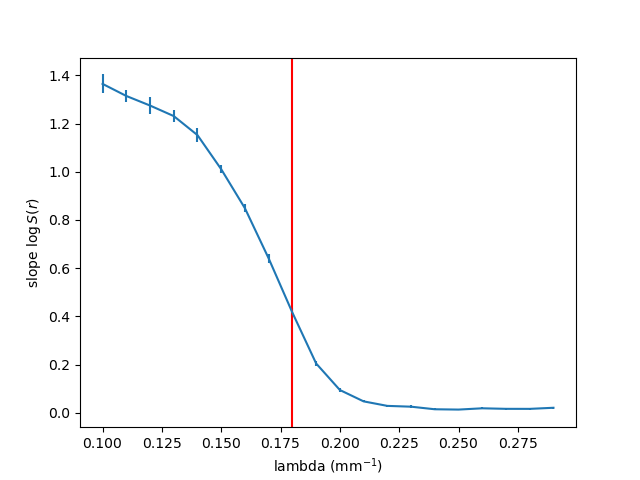

Text(0.5, 0, 'lambda (mm$^{-1}$)')

In [3]:
df = pd.read_csv('parametersRuns-autapse.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
for lamd in lambdas:
    print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    print(alphas)
    n = len(alphas)
    print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))
plt.figure()
plt.errorbar(lambdas, alphaMean, alphaSe)
plt.axvline(x = 0.18, color='r')
plt.ylabel('slope $\log S(r)$')
plt.xlabel('lambda (mm$^{-1}$)')

In [4]:
lambdas = np.unique(df['lambdas'].values)
1./lambdas

array([10.        ,  9.09090909,  8.33333333,  7.69230769,  7.14285714,
        6.66666667,  6.25      ,  5.88235294,  5.55555556,  5.26315789,
        5.        ,  4.76190476,  4.54545455,  4.34782609,  4.16666667,
        4.        ,  3.84615385,  3.7037037 ,  3.57142857,  3.44827586])

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29]
[8 7]


<IPython.core.display.Javascript object>


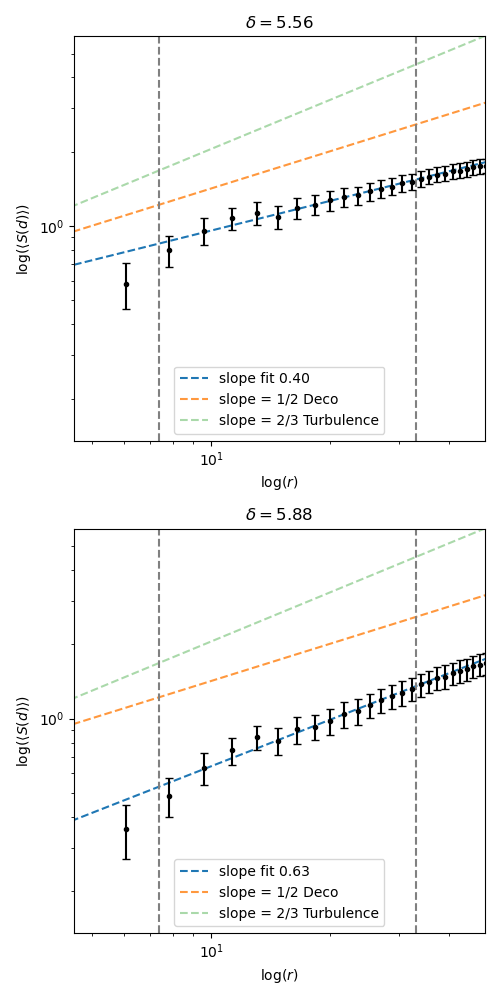

8 0.1799999999999999 5.555555555555558
7 0.1699999999999999 5.882352941176474


/tmp/ipykernel_29683/3463049519.py:25: RuntimeWarning: Mean of empty slice
  binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_29683/3463049519.py:29: RuntimeWarning: divide by zero encountered in log
  y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]
/tmp/ipykernel_29683/3463049519.py:25: RuntimeWarning: Mean of empty slice
  binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_29683/3463049519.py:29: RuntimeWarning: divide by zero encountered in log
  y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]


In [9]:
fitxlim = 3.5 

df = pd.read_csv('parametersRuns-autapse.csv')
dfBd = pd.read_csv('BdRuns-autapse.csv')

lambdas = np.unique(df['lambdas'].values)
print(lambdas)

linxs = np.array([np.where(np.isclose(lambdas,[1./d]))[0][0] for d in [5.55555556,5.88235294]])
print(linxs)

f,axs = plt.subplots(2,1,figsize=(5,10))

BdName = list(dfBd.columns)[1:]

rs = dfBd['bins'].values

for i,lindx in enumerate(linxs):
    print(lindx,lambdas[lindx],1./lambdas[lindx])
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = BdName[40*lindx:40*(lindx+1)]
    Bds = dfBd[cols].values
    Sds = 2*(Bds[0]-Bds) 
    
    binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
    binnedSdsePlot = np.nanstd(Sds[:,:],axis=1)/np.sqrt(40)
    
    x=np.log(rs)
    y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    xline = np.arange(1,5.5,0.1) #np.array([1,5.5])
    axs[i].plot(np.exp(xline), np.exp(alpha[0]*xline + alpha[1]), '--',color='tab:blue',label='slope fit '+"%.2f" % alpha[0])
    axs[i].plot(np.exp([0,5.5]),np.exp([-.8,-.8 + 5.5*(0.5)]),'--',color='tab:orange',alpha=0.8,label='slope = 1/2 Deco')
    axs[i].plot(np.exp([0,5.5]),np.exp([-.8,-.8 + 5.5*(0.66)]),'--',color='tab:green',alpha=0.4,label='slope = 2/3 Turbulence')
    
    #for j in range(40):
    #    axs[i].scatter(rs,Sds[:,j],s=0.2)
    axs[i].set_title(r'$\delta = '+str(np.round(1./lambdas[lindx],2))+'$')
    axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xticks(np.exp(np.arange(1.5,3.9,0.5)))
    axs[i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].minorticks_off()
    axs[i].set_xticklabels(np.arange(1.5,3.9,0.5))
    axs[i].set_yticks(np.exp(np.arange(-2.,1.77,1.)))
    axs[i].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[i].set_yticklabels(np.arange(-2.,1.77,1.))
    axs[i].set_xlim((np.exp(1.5),np.exp(3.9)))
    axs[i].set_ylim((np.exp(-2),np.exp(1.77)))
    #axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    axs[i].set_ylabel(r'$\log( \langle S(d) \rangle)$')
    axs[i].errorbar(rs,binnedSdmeanPlot,yerr=3*binnedSdsePlot,fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs[i].loglog()
    axs[i].legend()
    SdDf = pd.DataFrame({'d': rs,'binnedSd mean':binnedSdmeanPlot,'binnedSd se':binnedSdsePlot})
    SdDf.to_csv('binnedSd_'+str(np.round(1./lambdas[lindx],2))+'.csv')
plt.tight_layout()

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29]


<IPython.core.display.Javascript object>


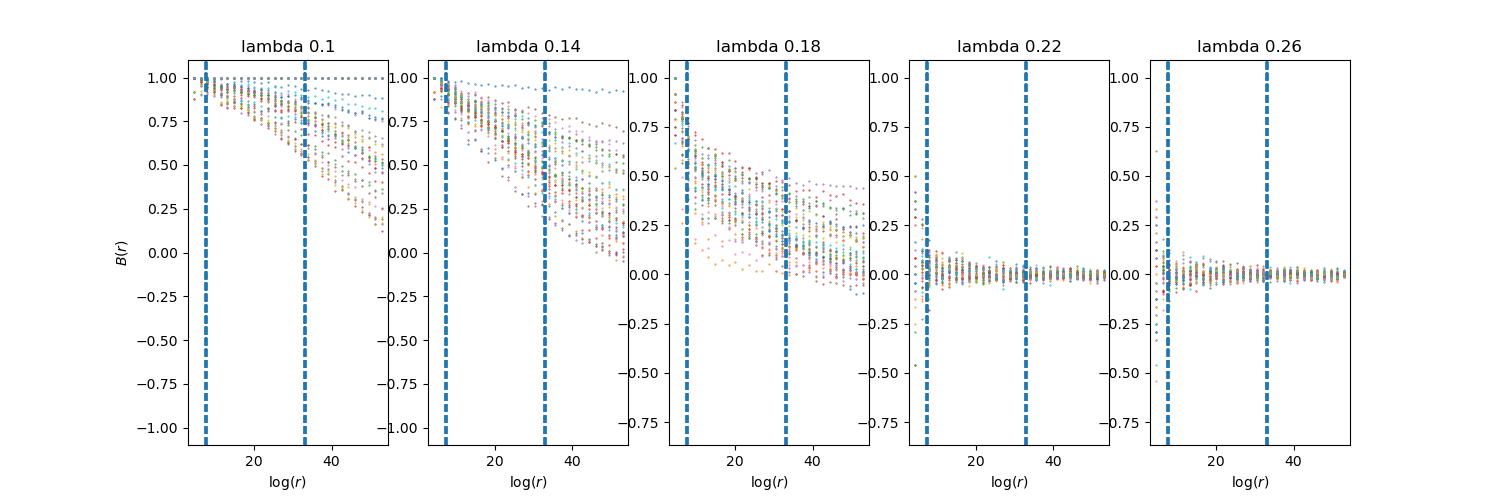

0 0.1
4 0.1399999999999999
8 0.1799999999999999
12 0.2199999999999999
16 0.2599999999999999


<IPython.core.display.Javascript object>


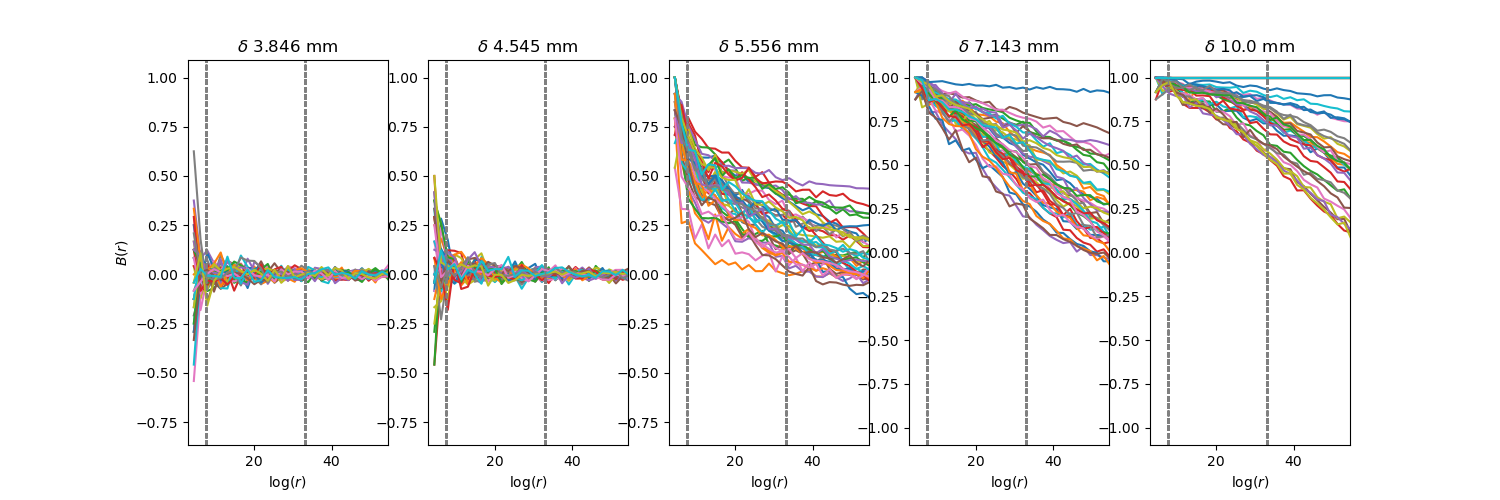

16 0.2599999999999999
12 0.2199999999999999
8 0.1799999999999999
4 0.1399999999999999
0 0.1


In [47]:
df = pd.read_csv('parametersRuns-autapse.csv')
dfBd = pd.read_csv('BdRuns-autapse.csv')

lambdas = np.unique(df['lambdas'].values)
print(lambdas)

f,axs = plt.subplots(1,5,figsize=(15,5))

BdName = list(dfBd.columns)[1:]

rs = dfBd['bins'].values

for i,lindx in enumerate(range(0,len(lambdas),4)):
    print(lindx,lambdas[lindx])
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = BdName[40*lindx:40*(lindx+1)]
    Bds = dfBd[cols].values
    #print(rs.shape,Bds[:,0].shape)
    #plt.figure()
    for j in range(40):
        axs[i].set_title('lambda '+str(np.round(lambdas[lindx],2)))
        axs[i].scatter(rs,Bds[:,j],s=0.2)
        axs[i].axvline(np.exp(2),linestyle='--')
        axs[i].axvline(np.exp(3.5),linestyle='--')
        axs[i].set_xlim((np.exp(1),np.exp(4)))
        axs[i].set_xlabel(r'$\log(r)$')
axs[0].set_ylabel(r'$B(r)$')

f,axs = plt.subplots(1,5,figsize=(15,5))

for i,lindx in enumerate(range(len(lambdas)-4,-1,-4)):
    print(lindx,lambdas[lindx])
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = BdName[40*lindx:40*(lindx+1)]
    Bds = dfBd[cols].values
    #print(rs.shape,Bds[:,0].shape)
    #plt.figure()
    for j in range(40):
        axs[i].set_title(r'$\delta$ '+str(np.round(1/lambdas[lindx],3))+' mm')
        axs[i].plot(rs,Bds[:,j])#,s=0.2)
        axs[i].axvline(np.exp(2),color='gray',linestyle='--', linewidth=1)
        axs[i].axvline(np.exp(3.5),color='gray',linestyle='--', linewidth=1)
        axs[i].set_xlim((np.exp(1),np.exp(4)))
        axs[i].set_xlabel(r'$\log(r)$')
axs[0].set_ylabel(r'$B(r)$')
plt.savefig('BrforDelta.png',dpi=600)




[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29]


<IPython.core.display.Javascript object>


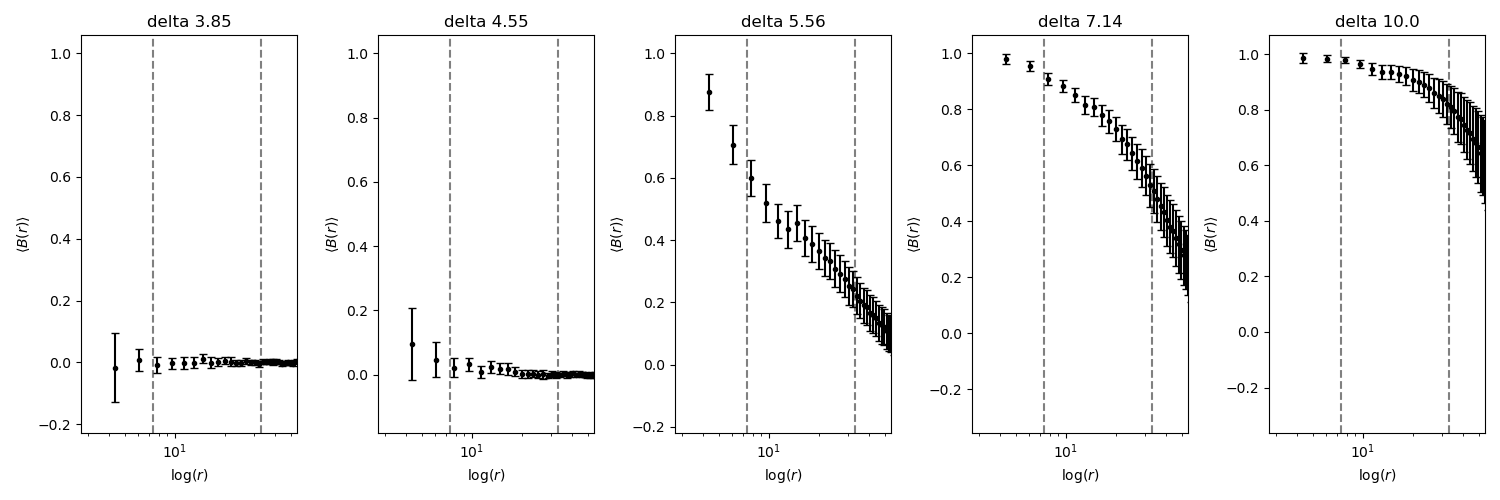

16 0.2599999999999999
12 0.2199999999999999
8 0.1799999999999999
4 0.1399999999999999
0 0.1


/tmp/ipykernel_4496/2422507019.py:20: RuntimeWarning: Mean of empty slice
  binnedBdmeanPlot = np.nanmean(Bds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_4496/2422507019.py:20: RuntimeWarning: Mean of empty slice
  binnedBdmeanPlot = np.nanmean(Bds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_4496/2422507019.py:20: RuntimeWarning: Mean of empty slice
  binnedBdmeanPlot = np.nanmean(Bds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_4496/2422507019.py:20: RuntimeW

<IPython.core.display.Javascript object>


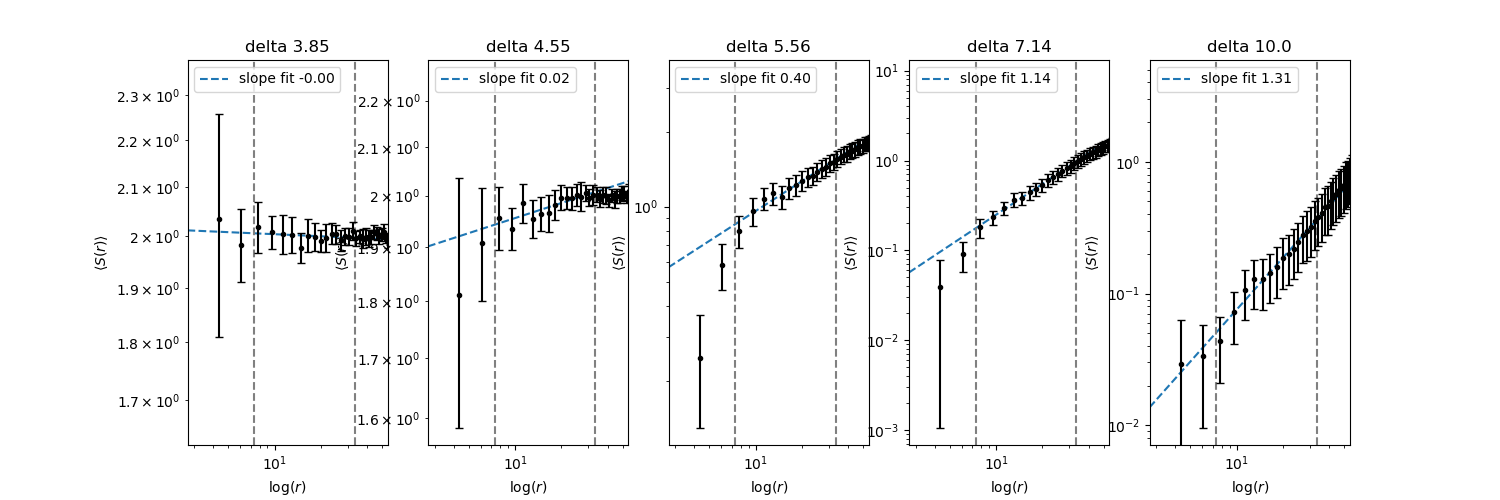

16 0.2599999999999999
12 0.2199999999999999
8 0.1799999999999999
4 0.1399999999999999
0 0.1


/tmp/ipykernel_4496/2422507019.py:49: RuntimeWarning: Mean of empty slice
  binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_4496/2422507019.py:53: RuntimeWarning: divide by zero encountered in log
  y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]
/tmp/ipykernel_4496/2422507019.py:49: RuntimeWarning: Mean of empty slice
  binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_4496/2422507019.py:53: RuntimeWarning: divide by zero encountered in log
  y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]
/tmp/ipykernel_4496/2422507019.py:49: RuntimeWarning: Mean of empty slice
  

In [61]:
df = pd.read_csv('parametersRuns-autapse.csv')
dfBd = pd.read_csv('BdRuns-autapse.csv')

lambdas = np.unique(df['lambdas'].values)
print(lambdas)

f,axs = plt.subplots(1,5,figsize=(15,5))

BdName = list(dfBd.columns)[1:]

rs = dfBd['bins'].values

for i,lindx in enumerate(range(len(lambdas)-4,-1,-4)):
    print(lindx,lambdas[lindx])
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = BdName[40*lindx:40*(lindx+1)]
    Bds = dfBd[cols].values
    #Sds = 2*(Bds[0]-Bds) 

    binnedBdmeanPlot = np.nanmean(Bds[:,:],axis=1)
    binnedBdsePlot = 3*np.nanstd(Bds[:,:],axis=1)/np.sqrt(40)
    
    #for j in range(40):
    #    axs[i].scatter(rs,Sds[:,j],s=0.2)
    axs[i].set_title('delta '+str(np.round(1./lambdas[lindx],2)))
    axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    axs[i].errorbar(rs,binnedBdmeanPlot,yerr=binnedBdsePlot,fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs[i].semilogx()
    #axs[i].legend()
    axs[i].set_ylabel(r'$\langle B(r) \rangle$')

plt.tight_layout()

f,axs = plt.subplots(1,5,figsize=(15,5))

for i,lindx in enumerate(range(len(lambdas)-4,-1,-4)):
    print(lindx,lambdas[lindx])
    #print(BdName[40*lindx:40*(lindx+1)])
    cols = BdName[40*lindx:40*(lindx+1)]
    Bds = dfBd[cols].values
    Sds = 2*(Bds[0]-Bds) 

    #binnedBdmeanPlot = np.nanmean(Bds[:,:],axis=1)
    #binnedBdsePlot = 3*np.nanstd(Bds[:,:],axis=1)/np.sqrt(40)
    
    binnedSdmeanPlot = np.nanmean(Sds[:,:],axis=1)
    binnedSdsePlot = 3*np.nanstd(Sds[:,:],axis=1)/np.sqrt(40)

    x=np.log(rs)
    y=np.log(binnedSdmeanPlot)#[np.logical_and(x>2, x<4)]
    gate= np.logical_and(np.logical_and(x>2, x<fitxlim),np.isfinite(y))
    x=x[gate]
    y=y[gate]

    A = np.vstack([x, np.ones(len(x))]).T
    # Direct least square regression
    alpha = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),y)
    xline = np.arange(1,5.5,0.1) #np.array([1,5.5])
    axs[i].plot(np.exp(xline), np.exp(alpha[0]*xline + alpha[1]), '--',color='tab:blue',label='slope fit '+"%.2f" % alpha[0])
    
    #for j in range(40):
    #    axs[i].scatter(rs,Sds[:,j],s=0.2)
    axs[i].set_title('delta '+str(np.round(1./lambdas[lindx],2)))
    axs[i].axvline(np.exp(2),linestyle='--',color='gray')
    axs[i].axvline(np.exp(fitxlim),linestyle='--',color='gray')
    axs[i].set_xlim((np.exp(1),np.exp(4)))
    axs[i].set_xlabel(r'$\log(r)$')
    axs[i].errorbar(rs,binnedSdmeanPlot,yerr=binnedSdsePlot,fmt='k.', ecolor='black',  capsize=3, capthick=1)
    axs[i].loglog()
    axs[i].legend()
    axs[i].set_ylabel(r'$\langle S(r) \rangle$')

[0.40038865 0.16117607 0.44756106 0.64892403 0.28131317 0.400648
 0.18897537 0.37644068 0.46760081 0.30083345 0.51001037 0.23927848
 0.58613323 0.46317677 0.36375732 0.61178952 0.40010792 0.42080105
 0.365445   0.49063909 0.56668946 0.48010439 0.18660663 0.6013318
 0.41421276 0.40892973 0.56078891 0.43403506 0.44469658 0.26196494
 0.37377118 0.42508766 0.34508423 0.3110242  0.52217623 0.3782697
 0.30411952 0.47196697 0.51731758 0.48160944]


<IPython.core.display.Javascript object>


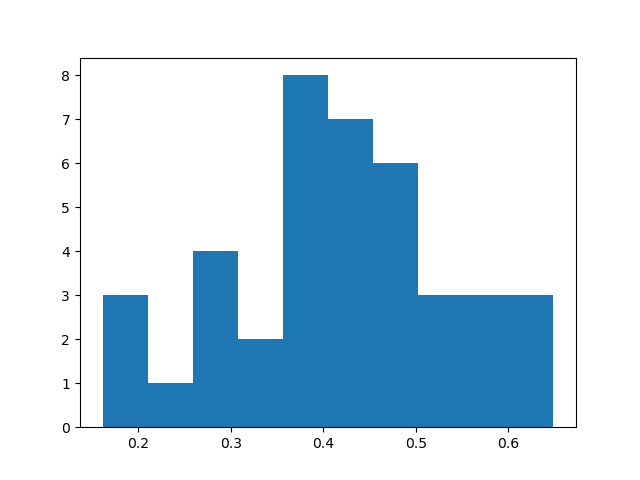

0.41536967547923015 0.11715741151400808 0.01876020001032097


40

In [6]:
df = pd.read_csv('parametersRuns-autapse.csv')
#print(df[df['lambdas'] == lambdas[8]])
alphas = df[df['lambdas'] ==  lambdas[8]]['alphaRuns'].values
print(alphas)

plt.figure()
plt.hist(alphas)

print(np.mean(alphas),np.std(alphas),stats.sem(alphas))

len(alphas)

In [7]:
lambdas[9]

0.1899999999999999

<IPython.core.display.Javascript object>


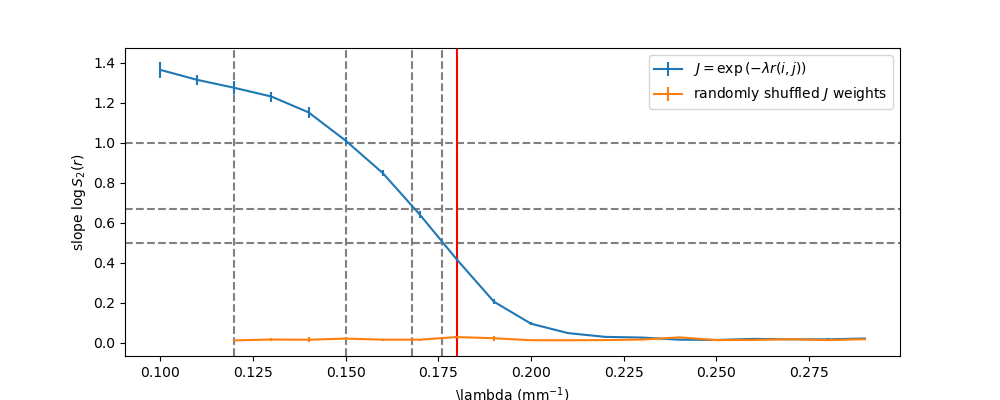

/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeW

In [8]:
f,ax=plt.subplots(1,figsize=(10,4))

df = pd.read_csv('parametersRuns-autapse.csv')
dfRand = pd.read_csv('parametersRuns-autapse-randomizeJ.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
for lamd in lambdas:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    #print(alphas)
    n = len(alphas)
    #print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))

lambdasRand = np.unique(dfRand['lambdas'].values)

alphaMeanRand = []
alphaSeRand = []
for lamd in lambdasRand:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
    alphasRand = alphasRand[np.isfinite(alphasRand)]
    #print(alphasRand)
    n = len(alphasRand)
    #print('n',n)
    alphaMeanRand.append(np.mean(alphasRand))
    alphaSeRand.append(stats.sem(alphasRand))
    
#plt.figure()

plt.axhline(y = 1., color='gray',linestyle='--')
plt.axhline(y = 2./3., color='gray',linestyle='--')
plt.axhline(y = 1./2., color='gray',linestyle='--')

plt.axvline(x = 0.12, color='gray',linestyle='--')
plt.axvline(x = 0.15, color='gray',linestyle='--')
plt.axvline(x = 0.168, color='gray',linestyle='--')
plt.axvline(x = 0.176, color='gray',linestyle='--')

plt.errorbar(lambdas, alphaMean, alphaSe,label=r'$J=\exp{(-\lambda r(i,j))}$')
plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
plt.axvline(x = 0.18, color='r')



plt.ylabel('slope $\log S_2(r)$')
plt.xlabel('\lambda (mm$^{-1}$)')
plt.legend()
#plt.savefig('lambdaVsSlope-wShaffled2.png',dpi=600)

<IPython.core.display.Javascript object>


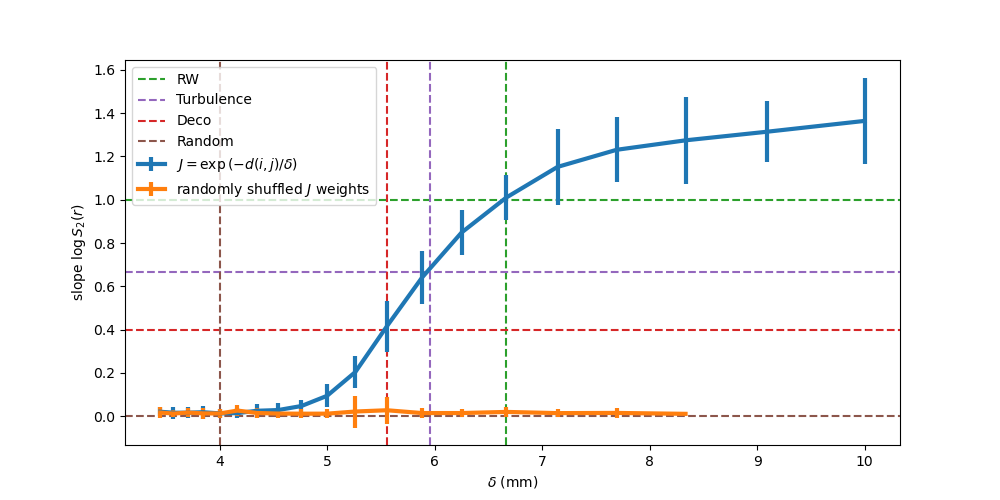

/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/gosti/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeW

In [12]:
from matplotlib.cm import get_cmap

name = "tab10"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list

f,ax=plt.subplots(1,figsize=(10,5))

df = pd.read_csv('parametersRuns-autapse.csv')
dfRand = pd.read_csv('parametersRuns-autapse-randomizeJ.csv')

lambdas = np.unique(df['lambdas'].values)

alphaMean = []
alphaSe = []
alphaStd = []
for lamd in lambdas:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphas = df[df['lambdas'] == lamd]['alphaRuns'].values
    alphas = alphas[np.isfinite(alphas)]
    #print(alphas)
    n = len(alphas)
    #print('n',n)
    alphaMean.append(np.mean(alphas))
    alphaSe.append(stats.sem(alphas))
    alphaStd.append(np.std(alphas))

lambdasRand = np.unique(dfRand['lambdas'].values)

alphaMeanRand = []
alphaSeRand = []
alphaStdRand = []
for lamd in lambdasRand:
    #print(lamd)
    #print(df[df['lambdas'] == lamd]['alphaRuns'])
    alphasRand = dfRand[dfRand['lambdas'] == lamd]['alphaRuns'].values
    alphasRand = alphasRand[np.isfinite(alphasRand)]
    #print(alphasRand)
    n = len(alphasRand)
    #print('n',n)
    alphaMeanRand.append(np.mean(alphasRand))
    alphaSeRand.append(stats.sem(alphasRand))
    alphaStdRand.append(np.std(alphasRand))
    
#plt.figure()

plt.axhline(y = 1., color=colors[2],label='RW',linestyle='--')
#plt.axhline(y = 1./2., color='gray',linestyle='--')

#plt.axvline(x = 1/0.12, color='gray',linestyle='--')
plt.axvline(x = 1/0.15, color=colors[2],linestyle='--')
plt.axhline(y = 2./3., color=colors[4],label='Turbulence',linestyle='--')
plt.axvline(x = 1/0.168, color=colors[4],linestyle='--')
#plt.axvline(x = 1/0.176, color='gray',linestyle='--')

plt.axhline(y = 2./5., color=colors[3],linestyle='--',label='Deco')
plt.axvline(x = 1/0.18, color=colors[3],linestyle='--')

plt.axhline(y = 0., color=colors[5],linestyle='--',label='Random')
plt.axvline(x = 1/0.25, color=colors[5],linestyle='--')

plt.errorbar(1./lambdas, alphaMean, alphaStd,label=r'$J=\exp{(-d(i,j)/\delta)}$',color=colors[0],linewidth=3.)
plt.errorbar(1./lambdasRand, alphaMeanRand, alphaStdRand, label=r'randomly shuffled $J$ weights',color=colors[1],linewidth=3.)




plt.ylabel('slope $\log S_2(r)$')
plt.xlabel(r'$\delta$ (mm)')
plt.legend()
#plt.savefig('deltaVsSlope-wShaffled2.png',dpi=600)

alphaDf = pd.DataFrame({'delta': 1./lambdas,'alphaMean':alphaMean,'alphaStd':alphaStd})
alphaDf.to_csv('alphaExpJ.csv')
alphaDfRand = pd.DataFrame({'delta': 1./lambdasRand,'alphaMean':alphaMeanRand,'alphaStd':alphaStdRand})
alphaDfRand.to_csv('alphaExpJ_Shuffled.csv')

<IPython.core.display.Javascript object>


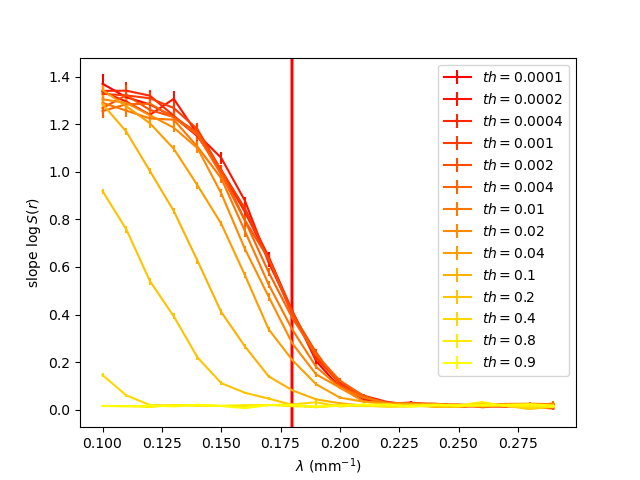

<IPython.core.display.Javascript object>


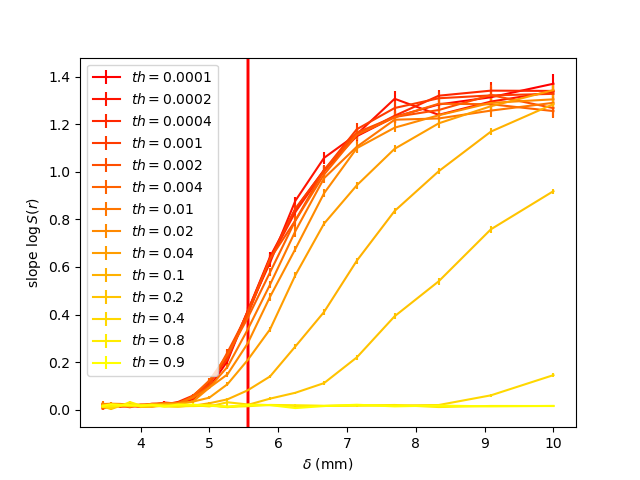

In [54]:
df = pd.read_csv('parametersRuns-autapse-thJ.csv')


ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,th in enumerate(ths):
    #print(th)
    #print(df[df['thsRuns']==th])
    dfTh = df[df['thsRuns']==th]
    lambdas = np.unique(dfTh['lambdas'].values)
    alphaMean = []
    alphaSe = []
    for lamd in lambdas:
        #print(lamd)
        #print(df[df['lambdas'] == lamd]['alphaRuns'])
        alphas = dfTh[dfTh['lambdas'] == lamd]['alphaRuns'].values
        alphas = alphas[np.isfinite(alphas)]
        #print(alphas)
        n = len(alphas)
        #print('n',n)
        alphaMean.append(np.mean(alphas))
        alphaSe.append(stats.sem(alphas))

    ax0.errorbar(lambdas, alphaMean, alphaSe,label=r'$th=$'+str(th), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax0.axvline(x = 0.18, color='r')
    ax0.set_ylabel('slope $\log S(r)$')
    ax0.set_xlabel(r'$\lambda$ (mm$^{-1}$)')
    ax0.legend()
    
    ax1.errorbar(1./lambdas, alphaMean, alphaSe,label=r'$th=$'+str(th), color=mycols[i])
    #plt.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    ax1.axvline(x = 1./0.18, color='r')
    ax1.set_ylabel('slope $\log S(r)$')
    ax1.set_xlabel(r'$\delta$ (mm)')
    ax1.legend()

In [55]:
df.tail(10)

,thsRuns,alphaRuns,lambdas,dilsRuns,run,deltas
11190,0.9,0.028645,0.29,0.998999,30,3.448276
11191,0.9,-0.005808,0.29,0.998999,31,3.448276
11192,0.9,0.009081,0.29,0.998999,32,3.448276
11193,0.9,-0.008781,0.29,0.998999,33,3.448276
11194,0.9,-0.018894,0.29,0.998999,34,3.448276
11195,0.9,0.007764,0.29,0.998999,35,3.448276
11196,0.9,0.027791,0.29,0.998999,36,3.448276
11197,0.9,-0.019747,0.29,0.998999,37,3.448276
11198,0.9,-0.000778,0.29,0.998999,38,3.448276
11199,0.9,0.018808,0.29,0.998999,39,3.448276


In [56]:
ths = df['lambdas'].values
print(ths)

[0.1  0.1  0.1  ... 0.29 0.29 0.29]


<IPython.core.display.Javascript object>


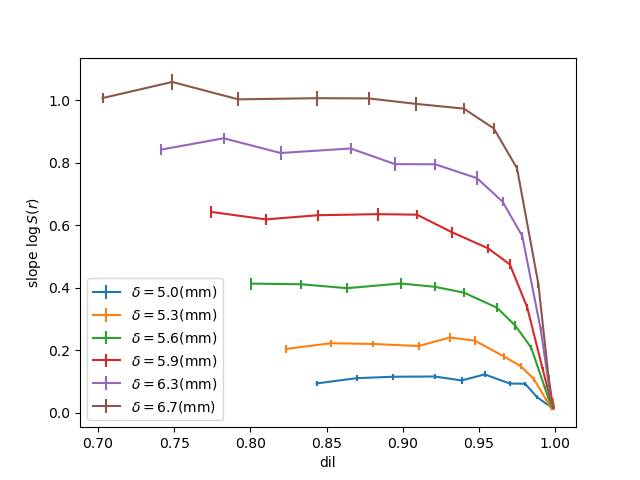

<IPython.core.display.Javascript object>


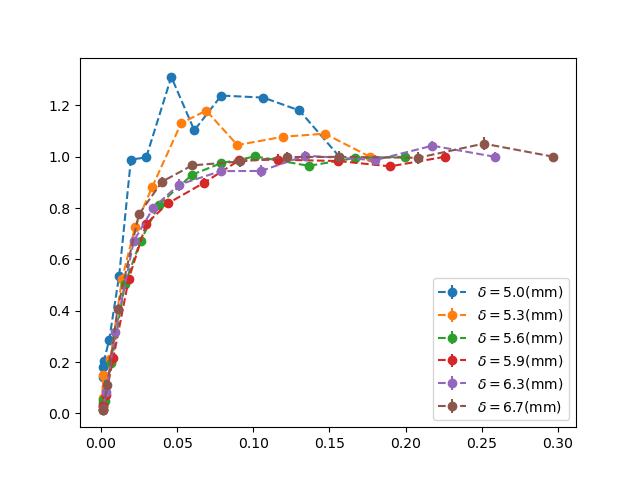

<IPython.core.display.Javascript object>


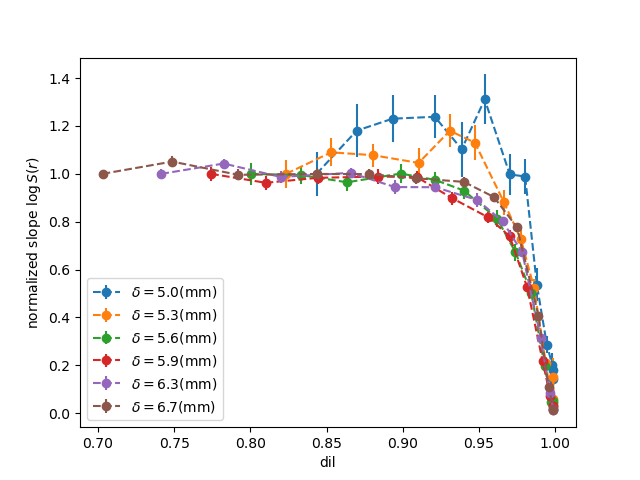

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

3.448275862068966
3.5714285714285725
3.703703703703705
3.846153846153848
4.000000000000002
4.166666666666668
4.347826086956522
4.545454545454547
4.761904761904763
5.000000000000001
[0.09333707801819671, 0.11017349175176465, 0.11484546151254109, 0.1155892644527261, 0.10294574063128159, 0.12237441941722449, 0.09311756961226172, 0.09229818149362368, 0.050119643207793295, 0.026649464415198054, 0.018932353064489236, 0.013274308345158258, 0.01682540517999274]
[1.         1.18038291 1.23043772 1.23840672 1.10294583 1.31110189
 0.99764822 0.98886941 0.53697463 0.28551852 0.2028385  0.14221903
 0.18026497]
5.263157894736843
[0.20391182225623491, 0.2222247594291055, 0.21984490986505167, 0.21321497791165295, 0.24059940908437477, 0.23053311432466356, 0.17969465966562387, 0.148179225173407, 0.10671922724284247, 0.04302964694259269, 0.009924872709118187, 0.03071070892895327, 0.01188607064362668]
[1.         1.08980812 1.07813714 1.04562342 1.17991888 1.13055296
 0.88123708 0.72668286 0.52335969 0.21

In [59]:
#df = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df['deltas'] = 1./df['lambdas'] 

deltas = np.unique(df['deltas'].values)
#ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
f,ax2 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,delta in enumerate(deltas):
    print(delta)
    #print(df[df['thsRuns']==th])
    if (delta > 5.) and (delta < 7.): 
        dfdlt = df[df['deltas']==delta]
        #plt.figure()
        #plt.scatter(dfdlt['thsRuns'].values,dfdlt['dil'].values)
        #print(dfdlt)
        #ths = np.unique(dfdlt['thsRuns'].values)
        dils = np.unique(dfdlt['dilsRuns'].values)
        #print(ths)
        #print(ths.size,dils.size)
        alphaMean = []
        alphaSe = []
        alphaMean0 = None
        alphaNormMean = []
        alphaNormSe = []
        for dil in dils:
            #print(lamd)
            #print(df[df['lambdas'] == lamd]['alphaRuns'])
            alphas = dfdlt[dfdlt['dilsRuns'] == dil]['alphaRuns'].values
            alphas = alphas[np.isfinite(alphas)]
            #print(alphas)
            n = len(alphas)
            #print('n',n)
            alphaMean.append(np.mean(alphas))
            alphaSe.append(stats.sem(alphas))
            if alphaMean0 == None: 
                alphaMean0 = np.mean(alphas)
            alphaNormMean.append(np.mean(alphas/alphaMean0))
            alphaNormSe.append(stats.sem(alphas/alphaMean0))
        #print(len(alphaMean))
        #print(len(alphaSe))
        print(alphaMean)
        print(alphaMean/alphaMean[0])
        #f,ax0 = plt.subplots()
        #f,ax1 = plt.subplots()
        ax0.errorbar(dils, alphaMean, alphaSe, label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')#, color=mycols[i])
        ax1.errorbar(1-dils,alphaMean/alphaMean[0], alphaSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
        ax2.errorbar(dils,alphaNormMean, alphaNormSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
    #ax0.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    #ax0.axvline(x = 0.18, color='r')
    ax0.set_ylabel('slope $\log S(r)$')
    ax0.set_xlabel(r'dil')
    #ax0.set_xscale('log')
    #ax2.set_xscale('log')
    #ax0.axvline(x = 0.18, color='r')
    ax2.set_ylabel('normalized slope $\log S(r)$')
    ax2.set_xlabel(r'dil')
    ax0.legend()
    ax1.legend()
    ax2.legend()

<IPython.core.display.Javascript object>


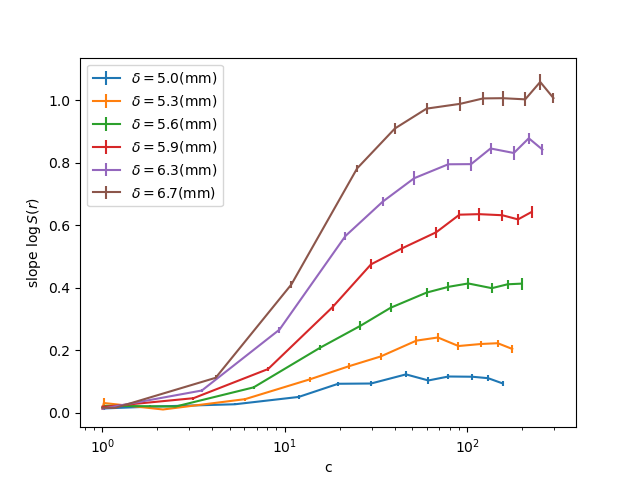

<IPython.core.display.Javascript object>


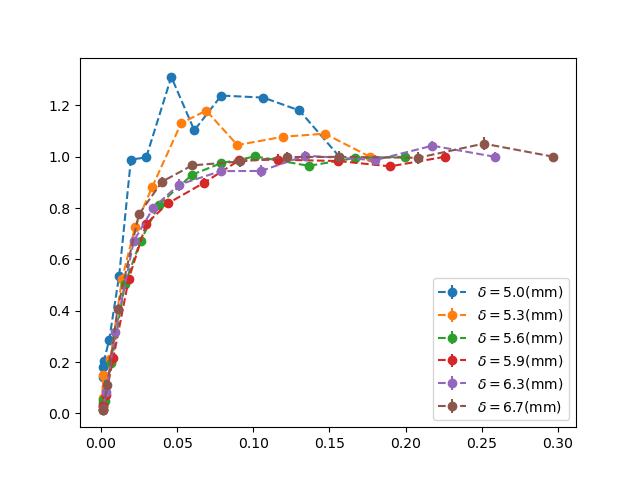

<IPython.core.display.Javascript object>


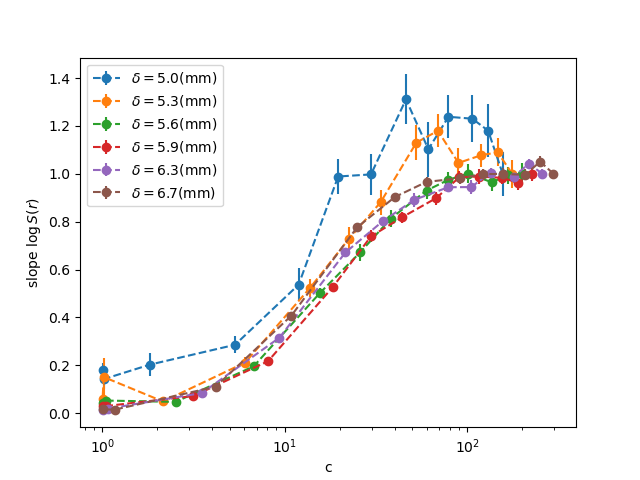

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

3.448275862068966
3.5714285714285725
3.703703703703705
3.846153846153848
4.000000000000002
4.166666666666668
4.347826086956522
4.545454545454547
4.761904761904763
5.000000000000001
[0.09333707801819671, 0.11017349175176465, 0.11484546151254109, 0.1155892644527261, 0.10294574063128159, 0.12237441941722449, 0.09311756961226172, 0.09229818149362368, 0.050119643207793295, 0.026649464415198054, 0.018932353064489236, 0.013274308345158258, 0.01682540517999274]
[1.         1.18038291 1.23043772 1.23840672 1.10294583 1.31110189
 0.99764822 0.98886941 0.53697463 0.28551852 0.2028385  0.14221903
 0.18026497]
5.263157894736843
[0.20391182225623491, 0.2222247594291055, 0.21984490986505167, 0.21321497791165295, 0.24059940908437477, 0.23053311432466356, 0.17969465966562387, 0.148179225173407, 0.10671922724284247, 0.04302964694259269, 0.009924872709118187, 0.03071070892895327, 0.01188607064362668]
[1.         1.08980812 1.07813714 1.04562342 1.17991888 1.13055296
 0.88123708 0.72668286 0.52335969 0.21

In [60]:
#df = pd.read_csv('parametersRuns-autapse-thJ.csv')
#df['deltas'] = 1./df['lambdas'] 

deltas = np.unique(df['deltas'].values)
#ths = np.unique(df['thsRuns'].values)

f,ax0 = plt.subplots()
f,ax1 = plt.subplots()
f,ax2 = plt.subplots()
mycols= plt.cm.autumn(np.linspace(0,1,len(ths)))

for i,delta in enumerate(deltas):
    print(delta)
    #print(df[df['thsRuns']==th])
    if (delta > 5.) and (delta < 7.): 
        dfdlt = df[df['deltas']==delta]
        #plt.figure()
        #plt.scatter(dfdlt['thsRuns'].values,dfdlt['dil'].values)
        #print(dfdlt)
        #ths = np.unique(dfdlt['thsRuns'].values)
        dils = np.unique(dfdlt['dilsRuns'].values)
        #print(ths)
        #print(ths.size,dils.size)
        alphaMean = []
        alphaSe = []
        alphaMean0 = None
        alphaNormMean = []
        alphaNormSe = []
        for dil in dils:
            #print(lamd)
            #print(df[df['lambdas'] == lamd]['alphaRuns'])
            alphas = dfdlt[dfdlt['dilsRuns'] == dil]['alphaRuns'].values
            alphas = alphas[np.isfinite(alphas)]
            #print(alphas)
            n = len(alphas)
            #print('n',n)
            alphaMean.append(np.mean(alphas))
            alphaSe.append(stats.sem(alphas))
            if alphaMean0 == None: 
                alphaMean0 = np.mean(alphas)
            alphaNormMean.append(np.mean(alphas/alphaMean0))
            alphaNormSe.append(stats.sem(alphas/alphaMean0))
        #print(len(alphaMean))
        #print(len(alphaSe))
        print(alphaMean)
        print(alphaMean/alphaMean[0])
        #f,ax0 = plt.subplots()
        #f,ax1 = plt.subplots()
        ax0.errorbar((1-dils)*N, alphaMean, alphaSe, label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')#, color=mycols[i])
        ax1.errorbar(1-dils,alphaMean/alphaMean[0], alphaSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
        ax2.errorbar((1-dils)*N,alphaNormMean, alphaNormSe, marker='o',linestyle='--', label=r'$\delta=$'+str(np.round(delta,1))+'(mm)')
    #ax0.errorbar(lambdasRand, alphaMeanRand, alphaSeRand, label=r'randomly shuffled $J$ weights')
    #ax0.axvline(x = 0.18, color='r')
    ax0.set_ylabel('slope $\log S(r)$')
    ax0.set_xlabel(r'c')
    ax0.set_xscale('log')
    ax2.set_xscale('log')
    #ax0.axvline(x = 0.18, color='r')
    ax2.set_ylabel('slope $\log S(r)$')
    ax2.set_xlabel(r'c')
    ax0.legend()
    ax1.legend()
    ax2.legend()

In [55]:
alphaMean/alphaMean[0]

array([1.        , 0.90414478, 0.77722553, 0.40794543, 0.11068308,
       0.01494289])

In [40]:
lambdas = np.unique(df['lambdas'].values)

In [41]:
delta = 0.5
dfdlt = df[df['deltas']==np.unique(df['deltas'])[9]]
ths = np.unique(dfdlt['thsRuns'].values)
ths

array([1.e-04, 2.e-04, 4.e-04, 1.e-03, 2.e-03, 4.e-03, 1.e-02, 2.e-02,
       4.e-02, 1.e-01, 2.e-01, 4.e-01])

In [80]:
 dils = np.unique(dfLmb['dil'].values)

5.000000000000003

time ij list 2.0860350131988525


<IPython.core.display.Javascript object>


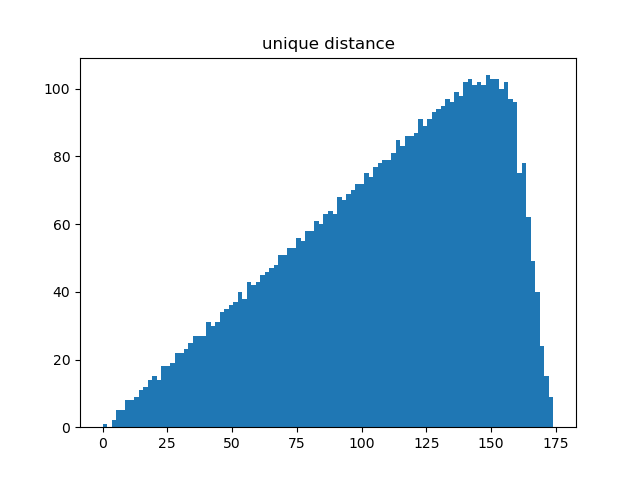

0.998998998998999


In [38]:
#import getCycles
import numpy as np
#import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance
import time

import turboBrainUtils as tb 

runs = 40
passi = 100#200
autapse = True
randomize = False

# # Parcellizzazione
# https://www.sciencedirect.com/science/article/pii/S2211124720314601?via%3Dihub
df = pd.read_csv('Schaefer2018_1000Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv')
df.head()
X = df['R']
Y = df['A']
Z = df['S']
N=len(X)

coords = np.array([X,Y,Z]).T
dist = distance.cdist(coords, coords, 'euclidean')
uniqDist,iListList,jListList = tb.sortIJbyDist(dist,N)
plt.figure()
h,bins,f=plt.hist(uniqDist,bins=100)
plt.title('unique distance')

lamda = 0.2#0.18
J = tb.makeJ(dist,lamda,autapse,randomize)
#print(J[:4,:4], (J<thJ)[:4,:4], 'num cut',np.sum(J<thJ), thJ)
J[J<0.8] = 0.
dil = np.sum( (np.sum(J==0) - N) / ( N * N- N) ) 

print(dil)

In [27]:
J[1,2]

0.0

<IPython.core.display.Javascript object>


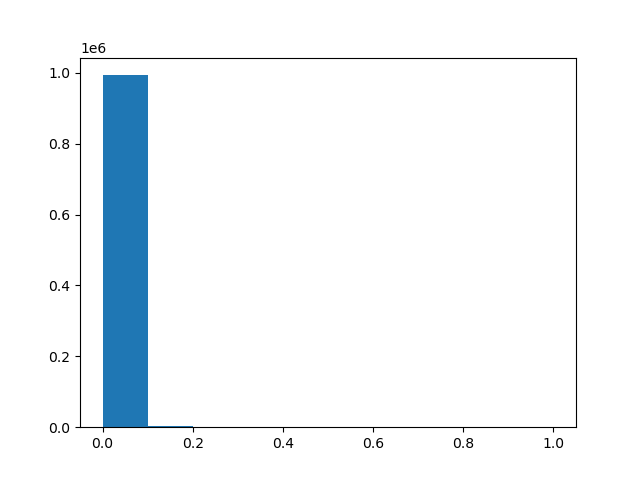

(array([9.93264e+05, 4.21800e+03, 1.16600e+03, 3.12000e+02, 4.00000e+01,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+03]),
 array([2.46381729e-14, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

In [17]:
plt.figure()
plt.hist(J.flatten())

In [21]:
np.sum(J>.80)

1000